## Bayesian Modeling ##

In [1]:
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

In [3]:
# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

In [4]:
# 导入模型
from src.Bayesian_new import *

### 0. Unit Test

#### 0.1 Base Test

In [5]:
p = Partition(4,4)

In [6]:
p.prototypes

[('2d_axis_pair',
  {0: (0.25, 0.25, 0.5, 0.5),
   1: (0.75, 0.25, 0.5, 0.5),
   2: (0.25, 0.75, 0.5, 0.5),
   3: (0.75, 0.75, 0.5, 0.5)}),
 ('2d_axis_pair',
  {0: (0.25, 0.5, 0.25, 0.5),
   1: (0.75, 0.5, 0.25, 0.5),
   2: (0.25, 0.5, 0.75, 0.5),
   3: (0.75, 0.5, 0.75, 0.5)}),
 ('2d_axis_pair',
  {0: (0.25, 0.5, 0.5, 0.25),
   1: (0.75, 0.5, 0.5, 0.25),
   2: (0.25, 0.5, 0.5, 0.75),
   3: (0.75, 0.5, 0.5, 0.75)}),
 ('2d_axis_pair',
  {0: (0.5, 0.25, 0.25, 0.5),
   1: (0.5, 0.75, 0.25, 0.5),
   2: (0.5, 0.25, 0.75, 0.5),
   3: (0.5, 0.75, 0.75, 0.5)}),
 ('2d_axis_pair',
  {0: (0.5, 0.25, 0.5, 0.25),
   1: (0.5, 0.75, 0.5, 0.25),
   2: (0.5, 0.25, 0.5, 0.75),
   3: (0.5, 0.75, 0.5, 0.75)}),
 ('2d_axis_pair',
  {0: (0.5, 0.5, 0.25, 0.25),
   1: (0.5, 0.5, 0.75, 0.25),
   2: (0.5, 0.5, 0.25, 0.75),
   3: (0.5, 0.5, 0.75, 0.75)}),
 ('2d_equality_sum',
  {0: (0.5, 0.16666666666666666, 0.5, 0.5),
   1: (0.5, 0.8333333333333334, 0.5, 0.5),
   2: (0.8333333333333334, 0.5, 0.5, 0.5),
   3: (0.

In [7]:
p.calc_likelihood_entry(5, (np.array([[0.1,0.2,0.3,0.4],[0.1,0.4,0.3,0.2],[0.4,0.2,0.3,0.1]]), np.array([3,2,3]), np.array([1,0,1])), 2.)

array([0.26337826, 0.74936102, 0.19091061])

In [10]:
p.calc_likelihood_entry(2, (np.array([[0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4]]), np.array([3,2,3]), np.array([1,0,1])), 2.)

array([0.29285594, 0.81655506, 0.29285594])

In [11]:
pl = PartitionLikelihood(BaseSet(range(10)), p)

In [12]:
pl.h_set

Base Set of (index, value)'s:
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [10]:
pl.get_likelihood((np.array([[0.1,0.2,0.3,0.4],[0.05,0.02,0.53,0.4],[0.1,0.2,0.3,0.4]]), np.array([3,2,3]), np.array([1,1,0])), beta=15., normalized=True)

array([[0.00538931, 0.00406884, 0.00266818, 0.01182219, 0.00833538,
        0.02414705, 0.20918334, 0.24987487, 0.27611911, 0.20839173],
       [0.00624016, 0.21553695, 0.11519967, 0.21592538, 0.1161825 ,
        0.04417619, 0.2087503 , 0.01871472, 0.04304554, 0.0162286 ],
       [0.1425153 , 0.14310868, 0.1437381 , 0.13962455, 0.14119142,
        0.13408612, 0.05093617, 0.03265058, 0.02085718, 0.0512919 ]])

In [11]:
spl = SoftPartitionLikelihood(BaseSet(range(10)), p, np.exp(np.linspace(0,5,10)))

In [ ]:
spl.get_likelihood((np.array([[0.1,0.2,0.3,0.4],[0.05,0.02,0.53,0.4],[0.1,0.2,0.3,0.4]]), np.array([3,2,3]), np.array([1,1,0])), normalized=True)

In [13]:
learning_data

,iSub,version,condition,iSession,iBlock,iTrial,neck_length,head_length,leg_length,tail_length,...,leg_angle,tail_angle,feature1,feature2,feature3,feature4,category,choice,feedback,choRT
0,1,1,1,1,1,1,0.474262,0.484076,0.096722,0.080176,...,0.5,0.5,0.096722,0.484076,0.080176,0.474262,1,1,1.0,15.639
1,1,1,1,1,1,2,0.556726,0.976765,0.280363,0.079595,...,0.5,0.5,0.280363,0.976765,0.079595,0.556726,2,1,1.0,31.626
2,1,1,1,1,1,3,0.154921,0.514583,0.335823,0.299767,...,0.5,0.5,0.335823,0.514583,0.299767,0.154921,2,1,1.0,37.057
3,1,1,1,1,1,4,0.554234,0.225965,0.892292,0.500937,...,0.5,0.5,0.892292,0.225965,0.500937,0.554234,4,2,1.0,6.335
4,1,1,1,1,1,5,0.215180,0.850173,0.891455,0.639999,...,0.5,0.5,0.891455,0.850173,0.639999,0.215180,4,2,1.0,7.111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11195,24,1,3,1,2,124,0.441382,0.785711,0.023709,0.153259,...,0.5,0.5,0.441382,0.785711,0.023709,0.153259,2,2,1.0,12.196
11196,24,1,3,1,2,125,0.866531,0.222335,0.289970,0.747357,...,0.5,0.5,0.866531,0.222335,0.289970,0.747357,3,3,1.0,5.314
11197,24,1,3,1,2,126,0.946735,0.187566,0.890659,0.816365,...,0.5,0.5,0.946735,0.187566,0.890659,0.816365,4,4,1.0,5.929
11198,24,1,3,1,2,127,0.645122,0.751123,0.497858,0.295268,...,0.5,0.5,0.645122,0.751123,0.497858,0.295268,3,4,0.5,17.862


#### 0.2 Model Test

#### (1) Base model

In [5]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [ ]:
# 假设全集
fitting_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==2:
        condition = subject_data['condition'].iloc[0]
        model = SingleRationalModel(config_base, condition=condition)
        print(iSub)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values)
        step_results = model.fit_trial_by_trial(s_data)
        fitting_results[iSub] = {
            'condition': condition,
            'step_results': step_results
        }

In [ ]:
# 口头汇报限制假设集
fitting_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==1:
        condition = subject_data['condition'].iloc[0]
        model = SingleRationalModel(config_base, condition=condition)
        print(iSub)
        data_1 = (subject_data[["feature1_oral", "feature2_oral", "feature3_oral", "feature4_oral"]].values,
                subject_data["choice"].values)
        limited_hypos_list = model.oral_generate_hypos(data_1)
        data_2 = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values)
        step_results = model.fit_trial_by_trial(data_2, limited_hypos_list)
        fitting_results[iSub] = {
            'condition': condition,
            'step_results': step_results
        }

In [ ]:
sub_results = fitting_results[1]

In [ ]:
step_results = sub_results['step_results']

#### (2) Forget model

In [5]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import ForgetModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_fgt

In [6]:
# 模型拟合
fitting_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==1:
        condition = subject_data['condition'].iloc[0]
        model_fgt = ForgetModel(config_fgt, condition=condition)
        print(iSub)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values, 
                subject_data["category"].values)
        optimize_results = model_fgt.optimize_params(s_data)
        fitting_results[iSub] = {
            'condition': condition,
            'best_params': optimize_results['best_params'],
            'best_error': optimize_results['best_error'],
            'best_step_results': optimize_results['best_step_results'],
            'optimize_results': optimize_results
        }

1


Gamma-W0:   0%|          | 0/100 [00:00<?, ?it/s]

Gamma-W0: 100%|██████████| 100/100 [03:33<00:00,  2.14s/it]


In [7]:
sub_results = fitting_results[1]['optimize_results']

### 1. batch processing ###

#### 1.1 Base

In [5]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [13]:
# 封装单个被试的拟合过程
def process_subject(iSub, subject_data, config):
    condition = subject_data['condition'].iloc[0]
    model_base = SingleRationalModel(config, condition=condition)
    
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
              subject_data["choice"].values,
              subject_data["feedback"].values)
    step_results = model_base.fit_trial_by_trial(s_data)

    return {
        'iSub': iSub,
        'condition': condition,
        'step_results': step_results
    }

# 并行拟合主流程
def parallel_fitting(learning_data, config, n_jobs):
    """并行拟合所有被试"""
    subjects = list(learning_data.groupby('iSub'))
    
    # 使用并行计算
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_subject)(iSub, sub_data, config)
        for iSub, sub_data in tqdm(subjects, desc="Processing Subjects")
    )
    
    # 整理结果到字典
    fitting_results = {res['iSub']: res for res in results}
    return fitting_results

In [14]:
if __name__ == '__main__':
    fitting_results = parallel_fitting(learning_data, config_base, n_jobs=24)

  0%|          | 0/256 [00:00<?, ?it/s]/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:203: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterior)
  0%|          | 0/256 [00:00<?, ?it/s]/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:203: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterior)
  0%|          | 0/128 [00:00<?, ?it/s]/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:203: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterior)
  2%|▏         | 2/128 [00:00<00:09, 13.69it/s]/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:203: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterior)
  0%|          | 1/1344 [00:00<03:31,  6.34it/s]/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engi

In [7]:
sub_results = fitting_results[1]

In [ ]:
sub_step_results = sub_results['step']

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
os.makedirs(result_path, exist_ok=True)

filename = f'M_Base_fitting_results.joblib'
joblib.dump(fitting_results, result_path / filename)

In [6]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
fitting_results = joblib.load(result_path / 'M_Base_fitting_results.joblib')

In [7]:
# 导入模型分析
import src.Bayesian.utils.model_evaluation as model_eval
importlib.reload(model_eval)
from src.Bayesian.utils.model_evaluation import ModelEval

model_eval = ModelEval()

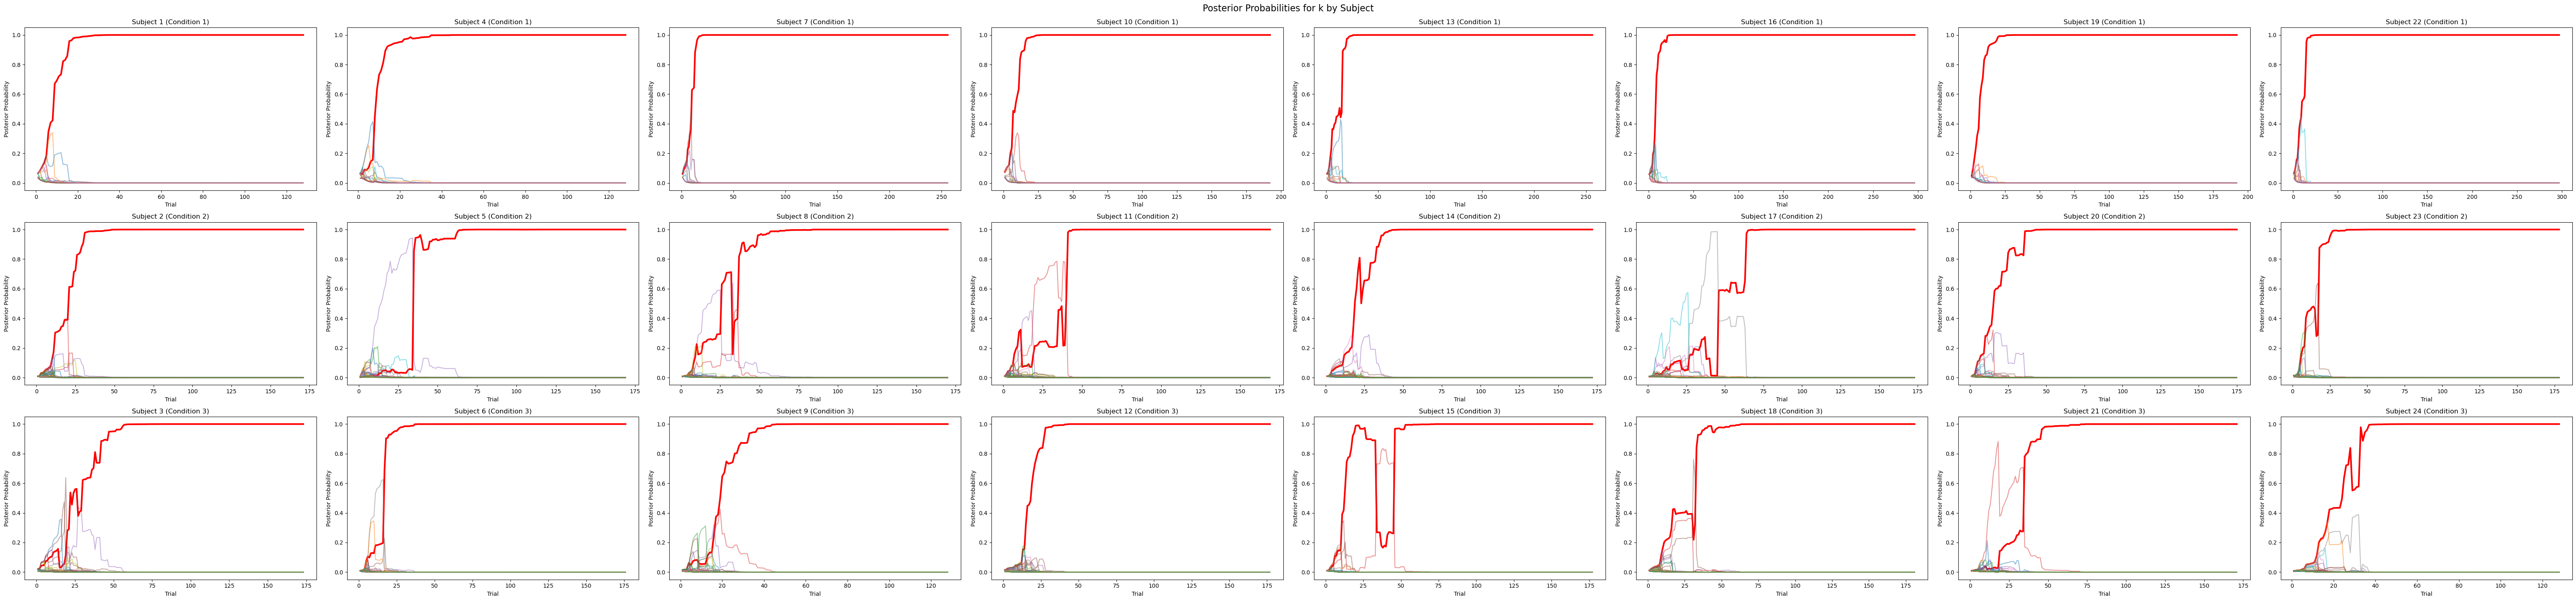

In [8]:
# 绘制最优参数变化图
# model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / f'M_Base_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Base_posteriors.png')

In [9]:
sub_results = fitting_results[2]

In [ ]:

# 计算预测准确率
# predictive_results = {}
# for iSub, fit_result in fitting_results.items():
#     subject_data = learning_data[learning_data['iSub'] == iSub]
#     step_results = fit_result['step_results']
#     condition = fit_result['condition']
    
#     predictions = model_eval.calculate_predictions(model_base, subject_data, step_results)
#     sliding_accuracy = model_eval.calculate_sliding_accuracy(predictions)
    
#     predictive_results[iSub] = {
#         'condition': condition,
#         'step_results': step_results,
#         'predictions': predictions,
#         'sliding_accuracy': sliding_accuracy
#     }

# # 绘制预测准确率变化图
# filename = f'M_Base_predictive_accuracy.png'
# model_eval.plot_predictive_accuracy(predictive_results, result_path / filename)

### 1.2 Forget ###

In [7]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import ForgetModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_fgt

In [8]:
# 封装单个被试的拟合过程
def process_subject(iSub, subject_data, config):
    condition = subject_data['condition'].iloc[0]
    model_fgt = ForgetModel(config, condition=condition)
    
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
            subject_data["choice"].values,
            subject_data["feedback"].values, 
            subject_data["category"].values)
    optimize_results = model_fgt.optimize_params(s_data)

    return {
        'iSub': iSub,
        'condition': condition,
        'optimize_results': optimize_results
    }

# 并行拟合主流程
def parallel_fitting(learning_data, config, n_jobs):
    """并行拟合所有被试"""
    subjects = list(learning_data.groupby('iSub'))
    
    # 使用并行计算
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_subject)(iSub, sub_data, config)
        for iSub, sub_data in tqdm(subjects, desc="Processing Subjects")
    )
    
    # 整理结果到字典
    fitting_results = {res['iSub']: res for res in results}
    return fitting_results

In [9]:
if __name__ == '__main__':
    fitting_results = parallel_fitting(learning_data, config_fgt, n_jobs=24)

Gamma-W0:   0%|          | 0/100 [00:00<?, ?it/s]/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:203: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterior)
Gamma-W0:   0%|          | 0/100 [00:00<?, ?it/s]/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:203: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterior)
/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:203: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterior)
/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:203: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterior)
/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:203: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterio

In [10]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
os.makedirs(result_path, exist_ok=True)

filename = f'M_Fgt_fitting_results.joblib'
joblib.dump(fitting_results, result_path / filename)

['/home/yangjiong/CategoryLearning/results/Bayesian_new/M_Fgt_fitting_results.joblib']

In [ ]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
fitting_results = joblib.load(result_path / 'M_Fgt_fitting_results.joblib')

In [33]:
sub_results = fitting_results[1]['optimize_results']

In [32]:
results = sub_results['optimize_results']['best_step_results']

In [ ]:
best_step_results = sub_results

In [22]:
for iSub in range(1,25):
    sub_results = fitting_results[iSub]
    print("iSub=", iSub, "condition=", sub_results['condition'], "(gamma,w0)=", sub_results['optimize_results']['best_params'])

iSub= 1 condition= 1 (gamma,w0)= (0.2, 0.2)
iSub= 2 condition= 2 (gamma,w0)= (0.8, 0.1)
iSub= 3 condition= 3 (gamma,w0)= (0.1, 1.0)
iSub= 4 condition= 1 (gamma,w0)= (0.1, 0.2)
iSub= 5 condition= 2 (gamma,w0)= (0.1, 1.0)
iSub= 6 condition= 3 (gamma,w0)= (0.1, 1.0)
iSub= 7 condition= 1 (gamma,w0)= (0.2, 0.3)
iSub= 8 condition= 2 (gamma,w0)= (0.1, 1.0)
iSub= 9 condition= 3 (gamma,w0)= (0.1, 1.0)
iSub= 10 condition= 1 (gamma,w0)= (0.6, 0.7)
iSub= 11 condition= 2 (gamma,w0)= (0.1, 1.0)
iSub= 12 condition= 3 (gamma,w0)= (0.1, 1.0)
iSub= 13 condition= 1 (gamma,w0)= (0.1, 1.0)
iSub= 14 condition= 2 (gamma,w0)= (0.9, 0.1)
iSub= 15 condition= 3 (gamma,w0)= (0.1, 1.0)
iSub= 16 condition= 1 (gamma,w0)= (0.3, 0.2)
iSub= 17 condition= 2 (gamma,w0)= (0.8, 0.6)
iSub= 18 condition= 3 (gamma,w0)= (0.9, 0.5)
iSub= 19 condition= 1 (gamma,w0)= (0.1, 0.2)
iSub= 20 condition= 2 (gamma,w0)= (0.1, 1.0)
iSub= 21 condition= 3 (gamma,w0)= (0.1, 1.0)
iSub= 22 condition= 1 (gamma,w0)= (0.1, 0.5)
iSub= 23 condition=

In [23]:
# 导入模型分析
import src.Bayesian.utils.model_evaluation_new as model_eval
importlib.reload(model_eval)
from src.Bayesian.utils.model_evaluation_new import ModelEval

model_eval = ModelEval()

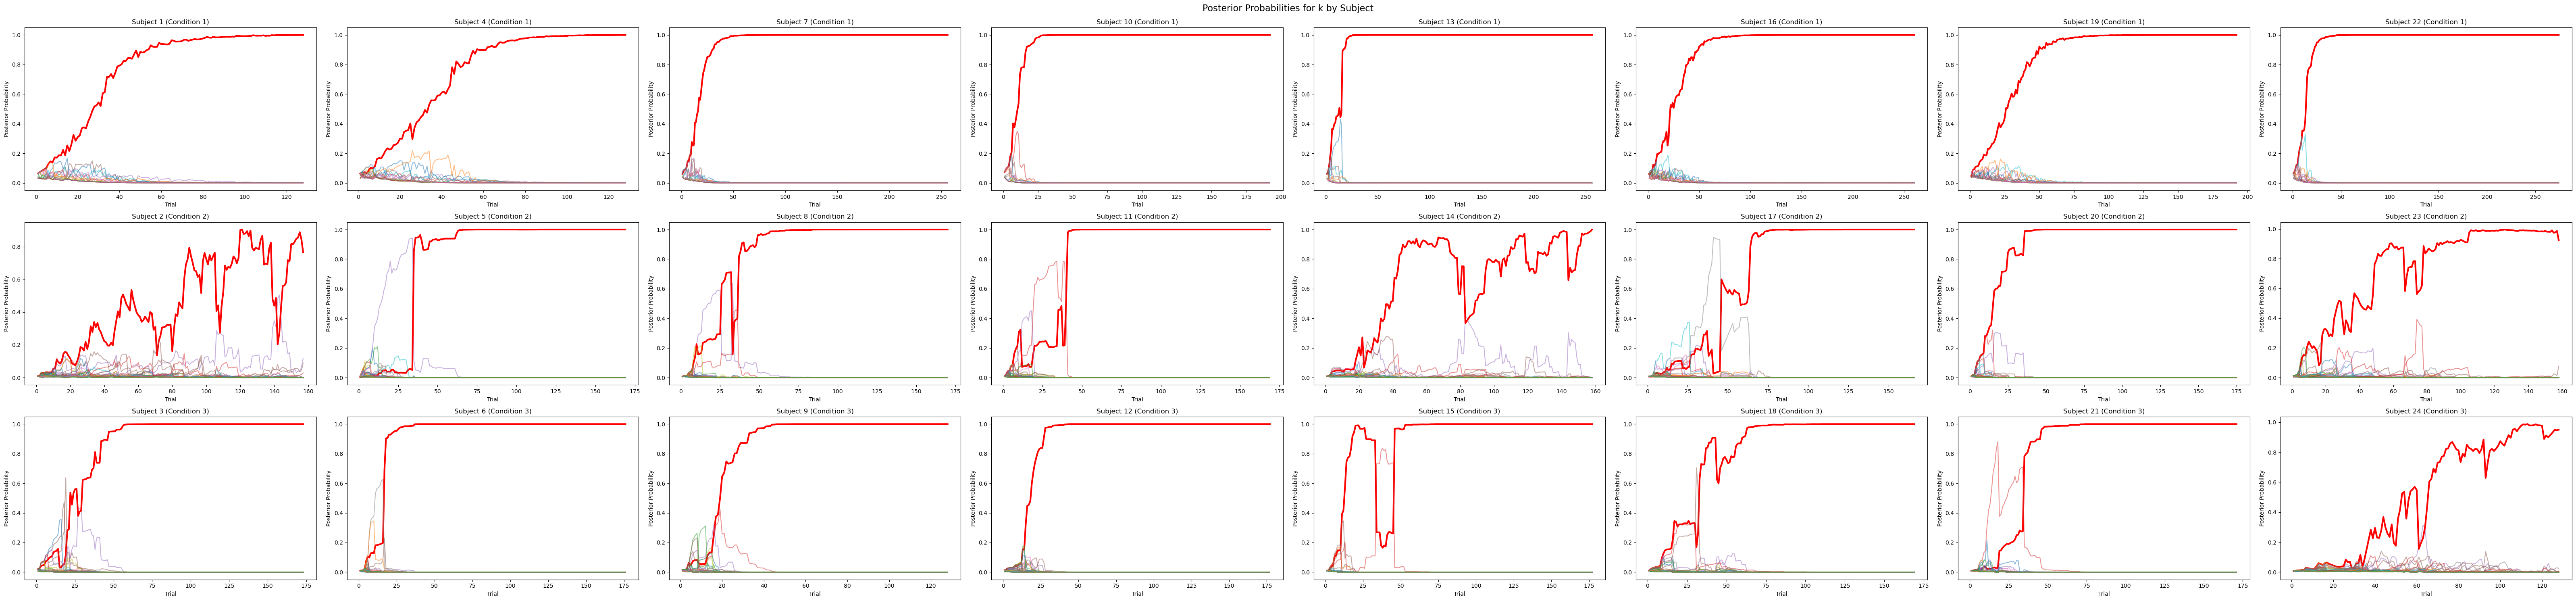

In [24]:
# 绘制最优参数变化图
model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / f'M_Fgt_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Fgt_posteriors.png')

In [25]:
# 绘制error grid图
model_eval.plot_error_grids(fitting_results, result_path / f'M_Fgt_errors.png')

In [ ]:
# # 加载拟合结果
# fitting_results = joblib.load(result_path / 'M_Fgt_fitting_results.joblib')

# # 绘制后验概率变化图
# filename = f'M_Fgt_posteriors.png'
# model_eval.plot_posterior_probabilities(fitting_results, result_path / filename)

# # 计算预测准确率
# predictive_results = {}
# for iSub, fit_result in fitting_results.items():
#     try:
#         subject_data = learning_data[learning_data['iSub'] == iSub]
#         step_results = fit_result['step_results']
#         condition = fit_result['condition']
        
#         predictions = model_eval.calculate_predictions(model_forget, subject_data, step_results)
#         sliding_accuracy = model_eval.calculate_sliding_accuracy(predictions)
        
#         predictive_results[iSub] = {
#             'condition': condition,
#             'step_results': step_results,
#             'predictions': predictions,
#             'sliding_accuracy': sliding_accuracy
#         }
#     except Exception as e:
#         print(f"Error processing predictions for subject {iSub}: {str(e)}")
#         continue

# # 绘制预测准确率变化图
# filename = f'M_Fgt_predictive_accuracy.png'
# model_eval.plot_predictive_accuracy(predictive_results, result_path / filename)

### 3. + Decision Noise ###

In [ ]:
# 导入模型
import src.Bayesian.M_dec as model_decision
importlib.reload(model_decision)
from src.Bayesian.M_dec import M_Dec

import src.Bayesian.config as config
importlib.reload(config)
from src.Bayesian.config import config_dec
model_decision = M_Dec(config_dec)

model_decision.set_centers(all_centers)

In [ ]:
# 模型拟合
fitting_results = {}
for iSub, subject_data in learning_data.groupby('iSub'):
    step_results = model_decision.fit_trial_by_trial(subject_data)
    fitting_results[iSub] = {
        'condition': subject_data['condition'].iloc[0],
        'step_results': step_results
    }

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian'
os.makedirs(result_path, exist_ok=True)

filename = f'M_Dec_fitting_results.joblib'
joblib.dump(fitting_results, result_path / filename)

In [ ]:
# 加载拟合结果
fitting_results = joblib.load(result_path / 'M_Dec_fitting_results.joblib')

# 绘制最优参数变化图
model_eval.plot_params_over_trials(fitting_results, 'beta', result_path / f'M_Dec_beta.png')
model_eval.plot_params_over_trials(fitting_results, 'phi', result_path / f'M_Dec_phi.png')

# 绘制k的后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Dec_posteriors.png')

# 计算预测准确率
predictive_results = {}
for iSub, fit_result in fitting_results.items():
    try:
        subject_data = learning_data[learning_data['iSub'] == iSub]
        step_results = fit_result['step_results']
        condition = fit_result['condition']
        
        predictions = model_eval.calculate_predictions(model_decision, subject_data, step_results)
        sliding_accuracy = model_eval.calculate_sliding_accuracy(predictions)
        
        predictive_results[iSub] = {
            'condition': condition,
            'step_results': step_results,
            'predictions': predictions,
            'sliding_accuracy': sliding_accuracy
        }
    except Exception as e:
        print(f"Error processing predictions for subject {iSub}: {str(e)}")
        continue

# 绘制预测准确率变化图
filename = f'M_Dec_predictive_accuracy.png'
model_eval.plot_predictive_accuracy(predictive_results, result_path / filename)

### 4. + Perceptive Noise ###

In [ ]:
learning_data = pd.read_csv(processed_path / 'Task2_processed_perceived.csv')

In [ ]:
# 导入基线模型
import src.Bayesian.M_base as model_base
importlib.reload(model_base)
from src.Bayesian.M_base import M_Base

import src.Bayesian.config as config
importlib.reload(config)
from src.Bayesian.config import config_base
model_base = M_Base(config_base)

model_base.set_centers(all_centers)

In [ ]:
# 模型拟合
fitting_results = {}
for iSub, subject_data in learning_data.groupby('iSub'):
    step_results = model_base.fit_trial_by_trial(subject_data)
    fitting_results[iSub] = {
        'condition': subject_data['condition'].iloc[0],
        'step_results': step_results
    }

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian'
os.makedirs(result_path, exist_ok=True)

filename = f'M_Perc_fitting_results.joblib'
joblib.dump(fitting_results, result_path / filename)

In [ ]:
# 加载拟合结果
fitting_results = joblib.load(result_path / 'M_Perc_fitting_results.joblib')

# 绘制最优参数变化图
model_eval.plot_params_over_trials(fitting_results, 'beta', result_path / f'M_Perc_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Perc_posteriors.png')

# 计算预测准确率
predictive_results = {}
for iSub, fit_result in fitting_results.items():
    subject_data = learning_data[learning_data['iSub'] == iSub]
    step_results = fit_result['step_results']
    condition = fit_result['condition']
    
    predictions = model_eval.calculate_predictions(model_base, subject_data, step_results)
    sliding_accuracy = model_eval.calculate_sliding_accuracy(predictions)
    
    predictive_results[iSub] = {
        'condition': condition,
        'step_results': step_results,
        'predictions': predictions,
        'sliding_accuracy': sliding_accuracy
    }

# 绘制预测准确率变化图
filename = f'M_Perc_predictive_accuracy.png'
model_eval.plot_predictive_accuracy(predictive_results, result_path / filename)

### 5. + Attention Weight ###

In [ ]:
# 导入基线模型
import src.Bayesian.M_base as model_base
importlib.reload(model_base)
from src.Bayesian.M_base import M_Base

import src.Bayesian.config as config
importlib.reload(config)
from src.Bayesian.config import config_base
model_base = M_Base(config_base)

model_base.set_centers(all_centers)

### 6. Full ###